# 기후에 따른 전력소비량 데이터
모로코 북부에 위치한 도시의 기후와 전력 소비량  
겨울에는 온화하고 비가 오지만, 여름에는 덥고 건조한 기후 특징을 나타낸다.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
df = pd.read_csv('powerconsumption.csv')
df.tail()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504
52415,12/30/2017 23:50,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820


#### 결측값이 존재하는지 확인

In [3]:
df.isnull().sum().sort_values(ascending=False)

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

#### 데이터의 특징 살펴보기

In [4]:
df.describe()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


In [5]:
df_corr = df.corr()

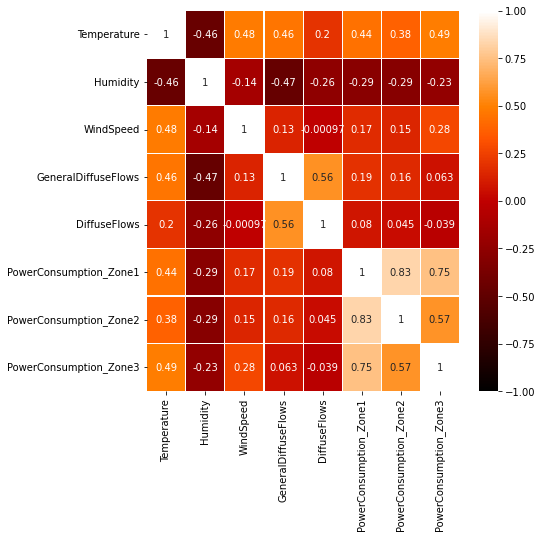

In [6]:
colormap = plt.cm.gist_heat
plt.figure(figsize=(7,7))
sns.heatmap(df_corr,linewidths=0.1, vmax=1, vmin=-1, cmap=colormap,linecolor='white',annot=True)
plt.show()

PowerConcsumption_Zone 1,2,3가 모로코의 도시 한곳을 구역으로 나눈 것이고,   
각각의 Zone끼리 correlation의 값의 차이가 크지 않으므로 전체적으로  
경향성을 예측하기 위해 PowerConsumption_Zone1에 모든 Zone 1,2,3을 모두 더했다.

In [9]:
df['PowerConsumption_Zone1'] = df['PowerConsumption_Zone1']+df['PowerConsumption_Zone2']+df['PowerConsumption_Zone3']
df_corr_sort = df_corr.sort_values("PowerConsumption_Zone1", ascending=False)
df_corr_sort['PowerConsumption_Zone1'].head()

PowerConsumption_Zone1    1.000000
PowerConsumption_Zone2    0.834519
PowerConsumption_Zone3    0.750733
Temperature               0.440221
GeneralDiffuseFlows       0.187965
Name: PowerConsumption_Zone1, dtype: float64

전력사용량을 기준으로 feature를 column list에 대입  

In [14]:
cols = ['PowerConsumption_Zone1','Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows']

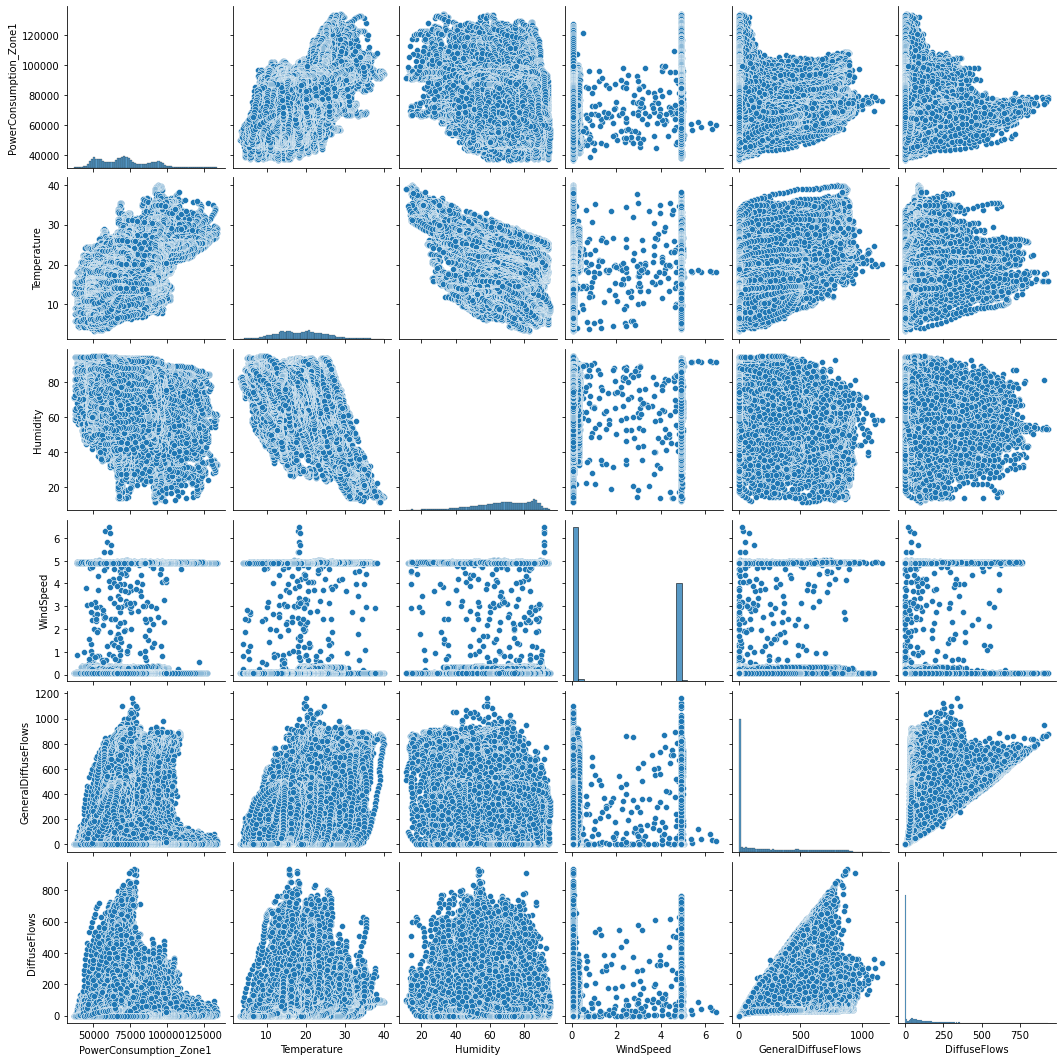

In [15]:
sns.pairplot(df[cols])
plt.show()

###Train set과 test set으로 나눔

In [16]:
cols_train = ['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows']
X_train_pre = df[cols_train]
y = df['PowerConsumption_Zone1'].values
X_train, X_test, y_train, y_test = train_test_split(X_train_pre, y, test_size=0.2)

###layer를 총 3개로 나눔  
###Model 생성

In [35]:
model = Sequential()
model.add(Dense(10, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                60        
                                                                 
 dense_5 (Dense)             (None, 30)                330       
                                                                 
 dense_6 (Dense)             (None, 1)                 31        
                                                                 
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mae'])

###모델 학습
###정확도로 모델 평가가 어려워 MAE로 모델 검증

In [37]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20)
model_path = './house.hdf5'
checkpointer = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 0, save_best_only = True)
history = model.fit(X_train, y_train, validation_split = 0.25, epochs = 2000, batch_size = 1000, callbacks = [early_stopping_callback,checkpointer])


Epoch 1/2000
32/32 [==============================] - 1s 8ms/step - loss: 5373608960.0000 - mae: 71250.9062 - val_loss: 5361798656.0000 - val_mae: 71224.7422
Epoch 2/2000
32/32 [==============================] - 0s 5ms/step - loss: 5367790080.0000 - mae: 71211.3438 - val_loss: 5354147328.0000 - val_mae: 71172.4375
Epoch 3/2000
32/32 [==============================] - 0s 4ms/step - loss: 5357230080.0000 - mae: 71139.1484 - val_loss: 5339545600.0000 - val_mae: 71072.1562
Epoch 4/2000
32/32 [==============================] - 0s 4ms/step - loss: 5336570880.0000 - mae: 70997.0312 - val_loss: 5310637568.0000 - val_mae: 70872.1406
Epoch 5/2000
32/32 [==============================] - 0s 4ms/step - loss: 5293848064.0000 - mae: 70700.7266 - val_loss: 5247946752.0000 - val_mae: 70435.3828
Epoch 6/2000
32/32 [==============================] - 0s 4ms/step - loss: 5205508608.0000 - mae: 70082.4297 - val_loss: 5128438784.0000 - val_mae: 69590.9766
Epoch 7/2000
32/32 [==============================] 

최종 MAE : 10767

In [38]:
real_prices = []
pred_prices = []
X_num = []

n_iter = 0
Y_prediction = model.predict(X_test).flatten()
for i in range(150):
  real = y_test[i]
  prediction = Y_prediction[i]
  print('실제: {:.2f}, 예상 : {:.2f}'.format(real,prediction))
  real_prices.append(real)
  pred_prices.append(prediction)
  n_iter += 1
  X_num.append(n_iter)

실제: 77785.57, 예상 : 78213.81
실제: 73555.55, 예상 : 61865.06
실제: 78320.38, 예상 : 77287.88
실제: 76044.12, 예상 : 74829.23
실제: 67687.89, 예상 : 71694.77
실제: 97711.90, 예상 : 67408.91
실제: 42128.89, 예상 : 63816.05
실제: 85298.86, 예상 : 56487.80
실제: 69642.35, 예상 : 63558.88
실제: 58618.24, 예상 : 62224.57
실제: 93550.95, 예상 : 68531.88
실제: 62970.09, 예상 : 69279.45
실제: 72162.21, 예상 : 89744.00
실제: 52826.02, 예상 : 62680.76
실제: 66395.58, 예상 : 60315.17
실제: 73941.30, 예상 : 66024.81
실제: 52362.04, 예상 : 66032.07
실제: 69950.75, 예상 : 71096.99
실제: 57712.53, 예상 : 65987.12
실제: 48446.17, 예상 : 57598.96
실제: 77019.33, 예상 : 81738.42
실제: 91939.52, 예상 : 68125.47
실제: 50906.30, 예상 : 66693.80
실제: 54947.77, 예상 : 68608.30
실제: 73184.29, 예상 : 75362.09
실제: 74409.88, 예상 : 68749.99
실제: 100953.04, 예상 : 80064.96
실제: 80468.99, 예상 : 77621.70
실제: 54933.02, 예상 : 60658.41
실제: 76116.10, 예상 : 71779.51
실제: 89362.56, 예상 : 80994.87
실제: 72615.69, 예상 : 70550.84
실제: 78305.84, 예상 : 80446.03
실제: 76310.53, 예상 : 82224.46
실제: 94449.80, 예상 : 83373.84
실제: 73863.84, 예상 : 

### 결과
### 전반적으로 Graph의 개형은 비슷함을 관찰 할 수 있음

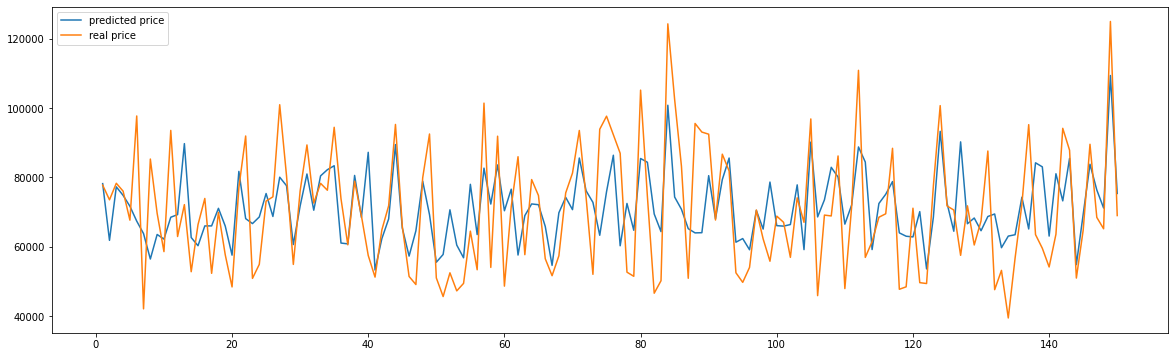

In [39]:
plt.figure(figsize=(20,6))
plt.plot(X_num, pred_prices, label = 'predicted price')
plt.plot(X_num, real_prices, label = 'real price')
plt.legend()
plt.show()

###다른 모델 테스트
Layer를 1개 늘리고 batch_size를 조정하여 MAE 관측

In [40]:
model = Sequential()
model.add(Dense(10, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 10)                60        
                                                                 
 dense_8 (Dense)             (None, 30)                330       
                                                                 
 dense_9 (Dense)             (None, 20)                620       
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,031
Trainable params: 1,031
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mae'])

In [44]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20)
model_path = './power.hdf5'
checkpointer = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 0, save_best_only = True)
history = model.fit(X_train, y_train, validation_split = 0.25, epochs = 2000, batch_size = 500, callbacks = [early_stopping_callback,checkpointer])


Epoch 1/2000
63/63 [==============================] - 0s 6ms/step - loss: 406643104.0000 - mae: 16172.4531 - val_loss: 395609056.0000 - val_mae: 16001.9492
Epoch 2/2000
63/63 [==============================] - 0s 6ms/step - loss: 402667808.0000 - mae: 16096.0205 - val_loss: 392167872.0000 - val_mae: 15946.5908
Epoch 3/2000
63/63 [==============================] - 0s 5ms/step - loss: 399144960.0000 - mae: 16027.5059 - val_loss: 388952928.0000 - val_mae: 15865.3789
Epoch 4/2000
63/63 [==============================] - 0s 4ms/step - loss: 395853248.0000 - mae: 15959.0049 - val_loss: 385863520.0000 - val_mae: 15810.6240
Epoch 5/2000
63/63 [==============================] - 0s 4ms/step - loss: 392676096.0000 - mae: 15896.1465 - val_loss: 382905696.0000 - val_mae: 15754.0459
Epoch 6/2000
63/63 [==============================] - 0s 3ms/step - loss: 389483392.0000 - mae: 15845.3818 - val_loss: 379951296.0000 - val_mae: 15682.4150
Epoch 7/2000
63/63 [==============================] - 0s 4ms/ste

In [45]:
real_prices = []
pred_prices = []
X_num = []

n_iter = 0
Y_prediction = model.predict(X_test).flatten()
for i in range(150):
  real = y_test[i]
  prediction = Y_prediction[i]
  print('실제: {:.2f}, 예상 : {:.2f}'.format(real,prediction))
  real_prices.append(real)
  pred_prices.append(prediction)
  n_iter += 1
  X_num.append(n_iter)

실제: 77785.57, 예상 : 80826.42
실제: 73555.55, 예상 : 62042.88
실제: 78320.38, 예상 : 74811.73
실제: 76044.12, 예상 : 76125.38
실제: 67687.89, 예상 : 74176.28
실제: 97711.90, 예상 : 64155.47
실제: 42128.89, 예상 : 62231.21
실제: 85298.86, 예상 : 54671.18
실제: 69642.35, 예상 : 65301.91
실제: 58618.24, 예상 : 65042.39
실제: 93550.95, 예상 : 64748.33
실제: 62970.09, 예상 : 68199.62
실제: 72162.21, 예상 : 91284.13
실제: 52826.02, 예상 : 62518.18
실제: 66395.58, 예상 : 59534.51
실제: 73941.30, 예상 : 66765.80
실제: 52362.04, 예상 : 72331.96
실제: 69950.75, 예상 : 70449.57
실제: 57712.53, 예상 : 65361.37
실제: 48446.17, 예상 : 57992.95
실제: 77019.33, 예상 : 81127.91
실제: 91939.52, 예상 : 64108.95
실제: 50906.30, 예상 : 67797.02
실제: 54947.77, 예상 : 67647.84
실제: 73184.29, 예상 : 81438.84
실제: 74409.88, 예상 : 73237.84
실제: 100953.04, 예상 : 80133.47
실제: 80468.99, 예상 : 77265.62
실제: 54933.02, 예상 : 68470.46
실제: 76116.10, 예상 : 62711.77
실제: 89362.56, 예상 : 74231.41
실제: 72615.69, 예상 : 72137.95
실제: 78305.84, 예상 : 82211.98
실제: 76310.53, 예상 : 86130.70
실제: 94449.80, 예상 : 73742.61
실제: 73863.84, 예상 : 

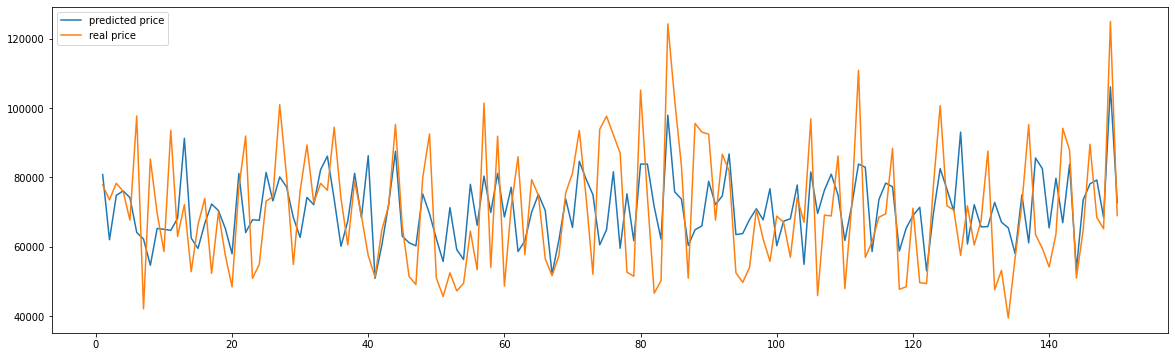

In [46]:
plt.figure(figsize=(20,6))
plt.plot(X_num, pred_prices, label = 'predicted price')
plt.plot(X_num, real_prices, label = 'real price')
plt.legend()
plt.show()

Layer를 한개 더 늘렸으나 MAE는 더 증가함을 관찰 할 수 있었음.